In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from verstack.stratified_continuous_split import scsplit # pip install verstack
from sklearn.model_selection import train_test_split

import sys
import pickle
from pickle import dump
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import seaborn as sns
import joblib
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from sklearn.ensemble import VotingRegressor

# !pip3 install textblob
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import time

import multiprocessing as mp


FEATURE ENGINEERING: hashtags --------------------


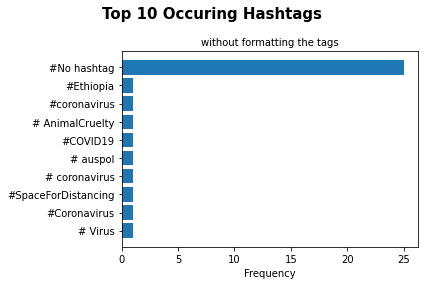

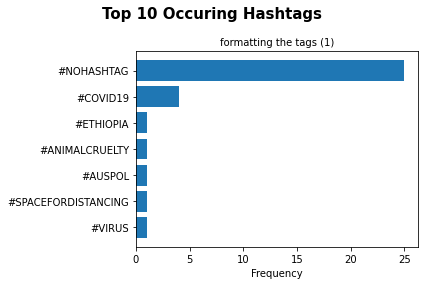

30
FEATURE ENGINEERING: timestamp --------------------
FEATURE ENGINEERING: text --------------------
FEATURE ENGINEERING: user_mentions and urls --------------------


In [5]:
######################################
# # # # Load the training data # # # #
######################################
# train_data = pd.read_csv("../../iCloud Drive (archive)/Documents/Polytechnique_X/INF554/Project/train.csv")
train_data = pd.read_csv("data/train.csv")      # todo: TRAIN
# train_data = pd.read_csv("data/evaluation.csv")   # todo: EVALUATION


print("FEATURE ENGINEERING: hashtags --------------------")
train_data = pd.read_csv("data/train.csv")
train_data["hashtags"] = train_data["hashtags"].fillna('No hashtag')

# train_data = train_data.head(30)
# Create a feature containing the number of hashtags per tweet
numb_hashtags_per_tweet = []
for hashtag in train_data["hashtags"]:
    if hashtag == 'No hashtag':
        res = 0
    else:
        res = hashtag.count(",") + 1
    numb_hashtags_per_tweet.append(res)

train_data["hashtags_count"] = numb_hashtags_per_tweet

# Percentage of tweets using hashtags
numb_hashtags_per_tweet = np.array(numb_hashtags_per_tweet)
hashtags_frac = len(numb_hashtags_per_tweet[numb_hashtags_per_tweet>0])/len(train_data["hashtags_count"])
# print("Percentage of tweets using hashtags is:", hashtags_frac)

# DETECT THE MOST IMPORTANT HASHTAGS
all_hashtags = []
for hashtag in train_data['hashtags']:  # grab all the tags and put them into a list
    hashtag = hashtag.split(',')
    for j in hashtag:
        all_hashtags.append(j)

all_hashtags = pd.Series(all_hashtags)


hash_freq = Counter(all_hashtags)   # get the frequency of appearing hashtags
common_hashtags = hash_freq.most_common(100)
# print("hash_freq = ", hash_freq)
# print("common_hashtags =", common_hashtags)

common_hashtags = hash_freq.most_common(10)       # save the top ten most common hashtags
taglabels = list(zip(*common_hashtags))[0][::-1]  # reverse the tuples to go from most frequent to least frequent
hashtaglabels = ['#'+i for i in taglabels]        # add a pound sign in front of each tag to make it clear that it's a hashtag
y_pos = np.arange(len(hashtaglabels))
usefreq = list(zip(*common_hashtags))[1][::-1]   # get the frequency part of the tuple

plt.figure()
plt.barh(y_pos, usefreq, align='center')  # plot horizontal barplot
plt.yticks(y_pos, hashtaglabels)
plt.suptitle("Top 10 Occuring Hashtags", fontsize=15, weight='bold')
plt.title("without formatting the tags", fontsize=10)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


# regularize the strings in the hashtags
all_hashtags = all_hashtags.str.replace(" ", "")
all_hashtags = all_hashtags.str.replace("-", "")
all_hashtags = all_hashtags.str.replace("_", "")
all_hashtags = all_hashtags.str.replace("ー", "")
all_hashtags = all_hashtags.str.replace("__", "")
all_hashtags = all_hashtags.str.upper()

COVID_labels = ['COVID19', 'COVID', 'CORONAVIRUS', 'CORONA', 'COV', 'COVID2019']

for i in range(len(all_hashtags)):
    if all_hashtags[i] in COVID_labels:
        all_hashtags[i] = 'COVID19'

hashfreq = Counter(all_hashtags) # get the frequency of appearing hashtags
common_hashtags = hashfreq.most_common(10) # save the top ten most common hashtags
taglabels = list(zip(*common_hashtags))[0][::-1] # reverse the tuples to go from most frequent to least frequent
hashtaglabels = ['#'+i for i in taglabels] # add a pound sign in front of each tag to make it clear that it's a hashtag
y_pos = np.arange(len(hashtaglabels))
usefreq = list(zip(*common_hashtags))[1][::-1] # get the frequency part of the tuple

plt.figure()
plt.barh(y_pos, usefreq, align='center') # plot horizontal barplot
plt.yticks(y_pos, hashtaglabels)
plt.suptitle("Top 10 Occuring Hashtags", fontsize=15, weight='bold')
plt.title("formatting the tags (1)", fontsize=10)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

train_data["hashtags_transf"] = train_data["hashtags"].str.replace(" ", "")
train_data["hashtags_transf"] = train_data["hashtags_transf"].str.replace("-", "")
train_data["hashtags_transf"] = train_data["hashtags_transf"].str.replace("_", "")
train_data["hashtags_transf"] = train_data["hashtags_transf"].str.replace("ー", "")
train_data["hashtags_transf"] = train_data["hashtags_transf"].str.replace("__", "")
train_data["hashtags_transf"] = train_data["hashtags_transf"].str.upper()

print(len(train_data["hashtags_transf"]))
for i in range(len(train_data["hashtags_transf"])):
    train_data["hashtags_transf"][i] = train_data["hashtags_transf"][i].split(',')
    for j in range(len(train_data["hashtags_transf"][i])):
        if train_data["hashtags_transf"][i][j] in COVID_labels:
            train_data["hashtags_transf"][i][j] = 'COVID'

train_data_hashtag_preprocessed = train_data


######################################
# # # # FEATURE ENGINEERING: timestamp
######################################
print("FEATURE ENGINEERING: timestamp --------------------")
train_data = pd.read_csv("data/train.csv")
# train_data = train_data.head(30)

train_data["timestamp_transf_fake"] = pd.to_datetime(train_data["timestamp"])
train_data["timestamp_transf_datetime"] = pd.to_datetime(round(train_data["timestamp"]/1000), unit='s')
train_data["timestamp_transf_date"] = train_data["timestamp_transf_datetime"].dt.date
train_data["timestamp_transf_time"] = train_data["timestamp_transf_datetime"].dt.time
train_data["timestamp_transf_hour"] = train_data["timestamp_transf_datetime"].dt.hour
train_data["timestamp_transf_month"] = train_data["timestamp_transf_datetime"].dt.month
train_data["timestamp_transf_week"] = train_data["timestamp_transf_datetime"].dt.week
train_data["timestamp_transf_day"] = train_data["timestamp_transf_datetime"].dt.day
train_data["timestamp_transf_weekday"] = train_data["timestamp_transf_datetime"].dt.dayofweek

train_data_timestamp_preprocessed = train_data


######################################
# # # # FEATURE ENGINEERING: text
######################################
print("FEATURE ENGINEERING: text --------------------")
train_data = pd.read_csv("data/train.csv")
# train_data = train_data.head(30)

train_data["text_length"] = train_data["text"]
for i in range(len(train_data["text"])):
    if i in [10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]:
        print("Reached course:", i)
    train_data["text_length"][i] = len(train_data["text"][i].split())


######################################
# # # # FEATURE ENGINEERING: user_mentions and urls
######################################
print("FEATURE ENGINEERING: user_mentions and urls --------------------")
train_data[["user_mentions_transf", "urls_transf"]] = train_data[["user_mentions", "urls"]].notnull().astype('int')
train_data["user_mentions_transf_2"] = train_data["user_mentions_transf"]
train_data["urls_transf_2"] = train_data["urls_transf"]

for i in range(len(train_data["user_mentions_transf"])):
    if i in [10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]:
        print("Reached course:", i)
    if train_data["user_mentions_transf"][i] == 1:
        train_data["user_mentions_transf_2"][i] = len(train_data["user_mentions"][i].split())
    if train_data["urls_transf"][i] == 1:
        train_data["urls_transf_2"][i] = len(train_data["urls"][i].split())


######################################
# # # # FULL PREPROCESSED DATASET
######################################

train_data = pd.concat([train_data_timestamp_preprocessed[["timestamp_transf_hour", "timestamp_transf_weekday"]],
                       train_data_hashtag_preprocessed[["hashtags_transf", "hashtags_count"]],
                       train_data[["timestamp", "retweet_count", "text", "user_verified", "user_statuses_count", "user_followers_count",
                                   "user_friends_count", "user_mentions_transf", "user_mentions_transf_2", "urls_transf", "urls_transf_2", "text_length"]]],
                      axis=1)

train_data['hashtags_transf'] = train_data['hashtags_transf'].apply(lambda x: ','.join(map(str, x)))
train_data = train_data[["timestamp", "timestamp_transf_hour", "timestamp_transf_weekday", "hashtags_count", "hashtags_transf", "user_verified", "user_statuses_count", "user_followers_count", "user_friends_count", "user_mentions_transf", "user_mentions_transf_2", "urls_transf", "urls_transf_2", "text_length", "text", "retweet_count"]]

FEATURE ENGINEERING: hashtags --------------------


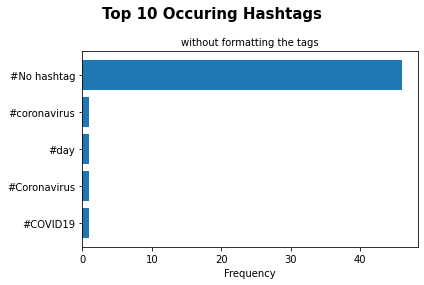

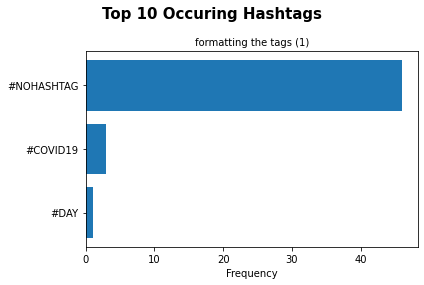

FEATURE ENGINEERING: timestamp --------------------
FEATURE ENGINEERING: text --------------------
FEATURE ENGINEERING: user_mentions and urls --------------------


In [8]:
######################################
# # # # FEATURE ENGINEERING: hashtags
######################################
print("FEATURE ENGINEERING: hashtags --------------------")
# rain_data = pd.read_csv("train.csv")
eval_data = pd.read_csv("data/evaluation.csv")   # todo: EVALUATION
eval_data["hashtags"] = eval_data["hashtags"].fillna('No hashtag')

# eval_data = eval_data.head(50)

# Create a feature containing the number of hashtags per tweet
numb_hashtags_per_tweet = []
for hashtag in eval_data["hashtags"]:
    if hashtag == 'No hashtag':
        res = 0
    else:
        res = hashtag.count(",") + 1
    numb_hashtags_per_tweet.append(res)

eval_data["hashtags_count"] = numb_hashtags_per_tweet

# Percentage of tweets using hashtags
numb_hashtags_per_tweet = np.array(numb_hashtags_per_tweet)
hashtags_frac = len(numb_hashtags_per_tweet[numb_hashtags_per_tweet>0])/len(eval_data["hashtags_count"])

# DETECT THE MOST IMPORTANT HASHTAGS
all_hashtags = []
for hashtag in eval_data['hashtags']:  # grab all the tags and put them into a list
    hashtag = hashtag.split(',')
    for j in hashtag:
        all_hashtags.append(j)

all_hashtags = pd.Series(all_hashtags)

hash_freq = Counter(all_hashtags)   # get the frequency of appearing hashtags
common_hashtags = hash_freq.most_common(100)

common_hashtags = hash_freq.most_common(10)       # save the top ten most common hashtags
taglabels = list(zip(*common_hashtags))[0][::-1]  # reverse the tuples to go from most frequent to least frequent
hashtaglabels = ['#'+i for i in taglabels]        # add a pound sign in front of each tag to make it clear that it's a hashtag
y_pos = np.arange(len(hashtaglabels))
usefreq = list(zip(*common_hashtags))[1][::-1]   # get the frequency part of the tuple

plt.figure()
plt.barh(y_pos, usefreq, align='center')  # plot horizontal barplot
plt.yticks(y_pos, hashtaglabels)
plt.suptitle("Top 10 Occuring Hashtags", fontsize=15, weight='bold')
plt.title("without formatting the tags", fontsize=10)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


# regularize the strings in the hashtags
all_hashtags = all_hashtags.str.replace(" ", "")
all_hashtags = all_hashtags.str.replace("-", "")
all_hashtags = all_hashtags.str.replace("_", "")
all_hashtags = all_hashtags.str.replace("ー", "")
all_hashtags = all_hashtags.str.replace("__", "")
all_hashtags = all_hashtags.str.upper()

COVID_labels = ['COVID19', 'COVID', 'CORONAVIRUS', 'CORONA', 'COV', 'COVID2019']

for i in range(len(all_hashtags)):
    if all_hashtags[i] in COVID_labels:
        all_hashtags[i] = 'COVID19'

hashfreq = Counter(all_hashtags) # get the frequency of appearing hashtags
common_hashtags = hashfreq.most_common(10) # save the top ten most common hashtags
taglabels = list(zip(*common_hashtags))[0][::-1] # reverse the tuples to go from most frequent to least frequent
hashtaglabels = ['#'+i for i in taglabels] # add a pound sign in front of each tag to make it clear that it's a hashtag
y_pos = np.arange(len(hashtaglabels))
usefreq = list(zip(*common_hashtags))[1][::-1] # get the frequency part of the tuple

plt.figure()
plt.barh(y_pos, usefreq, align='center') # plot horizontal barplot
plt.yticks(y_pos, hashtaglabels)
plt.suptitle("Top 10 Occuring Hashtags", fontsize=15, weight='bold')
plt.title("formatting the tags (1)", fontsize=10)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# USE ONLY THE MOST IMPORTANT HASHTAGS
# Create a Serie containing only the transformed and most used hashtags
# train_data["hashtags_transf"] = train_data["hashtags"].str.replace(" ", "").replace("-", "").replace("_", "").replace("ー", "").replace("__", "")

eval_data["hashtags_transf"] = eval_data["hashtags"].str.replace(" ", "")
eval_data["hashtags_transf"] = eval_data["hashtags_transf"].str.replace("-", "")
eval_data["hashtags_transf"] = eval_data["hashtags_transf"].str.replace("_", "")
eval_data["hashtags_transf"] = eval_data["hashtags_transf"].str.replace("ー", "")
eval_data["hashtags_transf"] = eval_data["hashtags_transf"].str.replace("__", "")
eval_data["hashtags_transf"] = eval_data["hashtags_transf"].str.upper()

for i in range(len(eval_data["hashtags_transf"])):
    eval_data["hashtags_transf"][i] = eval_data["hashtags_transf"][i].split(',')
    for j in range(len(eval_data["hashtags_transf"][i])):
        if eval_data["hashtags_transf"][i][j] in COVID_labels:
            eval_data["hashtags_transf"][i][j] = 'COVID'

# dump(train_data, open('train_data_hashtag_preprocessed.csv', 'wb'))   # todo: TRAIN
# dump(train_data, open('evaluation_hashtag_preprocessed.csv', 'wb'))    # todo: EVALUATION

eval_data_hashtag_preprocessed = eval_data


######################################
# # # # FEATURE ENGINEERING: timestamp
######################################
print("FEATURE ENGINEERING: timestamp --------------------")
# train_data = pd.read_csv("train.csv")
eval_data = pd.read_csv("data/evaluation.csv")   # todo: EVALUATION
# eval_data = eval_data.head(50)

eval_data["timestamp_transf_fake"] = pd.to_datetime(eval_data["timestamp"])
eval_data["timestamp_transf_datetime"] = pd.to_datetime(round(eval_data["timestamp"]/1000), unit='s')
eval_data["timestamp_transf_date"] = eval_data["timestamp_transf_datetime"].dt.date
eval_data["timestamp_transf_time"] = eval_data["timestamp_transf_datetime"].dt.time
eval_data["timestamp_transf_hour"] = eval_data["timestamp_transf_datetime"].dt.hour
eval_data["timestamp_transf_month"] = eval_data["timestamp_transf_datetime"].dt.month
eval_data["timestamp_transf_week"] = eval_data["timestamp_transf_datetime"].dt.week
eval_data["timestamp_transf_day"] = eval_data["timestamp_transf_datetime"].dt.day
eval_data["timestamp_transf_weekday"] = eval_data["timestamp_transf_datetime"].dt.dayofweek

eval_data_timestamp_preprocessed = eval_data


######################################
# # # # FEATURE ENGINEERING: text
######################################
print("FEATURE ENGINEERING: text --------------------")
# train_data = pd.read_csv("train.csv")
eval_data = pd.read_csv("data/evaluation.csv")   # todo: EVALUATION
# eval_data = eval_data.head(50)

eval_data["text_length"] = eval_data["text"]
for i in range(len(eval_data["text"])):
    if i in [10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]:
        print("Reached course:", i)
    eval_data["text_length"][i] = len(eval_data["text"][i].split())


######################################
# # # # FEATURE ENGINEERING: user_mentions and urls
######################################
print("FEATURE ENGINEERING: user_mentions and urls --------------------")
eval_data[["user_mentions_transf", "urls_transf"]] = eval_data[["user_mentions", "urls"]].notnull().astype('int')
eval_data["user_mentions_transf_2"] = eval_data["user_mentions_transf"]
eval_data["urls_transf_2"] = eval_data["urls_transf"]

for i in range(len(eval_data["user_mentions_transf"])):
    if i in [10000, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]:
        print("Reached course:", i)
    if eval_data["user_mentions_transf"][i] == 1:
        eval_data["user_mentions_transf_2"][i] = len(eval_data["user_mentions"][i].split())
    if eval_data["urls_transf"][i] == 1:
        eval_data["urls_transf_2"][i] = len(eval_data["urls"][i].split())


######################################
# # # # FULL PREPROCESSED DATASET
######################################

# todo: TRAIN
eval_data = pd.concat([eval_data_timestamp_preprocessed[["timestamp_transf_hour", "timestamp_transf_weekday"]],
                       eval_data_hashtag_preprocessed[["hashtags_transf", "hashtags_count"]],
                       eval_data[["timestamp", "text", "user_verified", "user_statuses_count", "user_followers_count",
                                   "user_friends_count", "user_mentions_transf", "user_mentions_transf_2", "urls_transf", "urls_transf_2", "text_length"]]],
                      axis=1)

eval_data['hashtags_transf'] = eval_data['hashtags_transf'].apply(lambda x: ','.join(map(str, x)))
eval_data = eval_data[["timestamp", "timestamp_transf_hour", "timestamp_transf_weekday", "hashtags_count", "hashtags_transf", "user_verified", "user_statuses_count", "user_followers_count", "user_friends_count", "user_mentions_transf", "user_mentions_transf_2", "urls_transf", "urls_transf_2", "text_length", "text"]]

In [15]:
def senti_pol(x):
    # sentiment ananlysis
    return TextBlob(x).sentiment.polarity

def senti_subj(x):
    return TextBlob(x).sentiment.subjectivity
    
def get_data(train_data, eval_data, training=-1,testing=-1,all_dataset=False):
    train_data_prepro = train_data
#     train_data = pd.read_csv("data/train.csv").head(len(train_data))
    eval_data_prepro = eval_data
#     eval_data = pd.read_csv("data/evaluation.csv").head(len(eval_data))
    
    eval_data_prepro = eval_data_prepro.drop(['timestamp_transf_hour',"timestamp_transf_weekday"],axis=1)
    train_data_prepro = train_data_prepro.drop(['timestamp_transf_hour',"timestamp_transf_weekday"],axis=1)
    
    def add_sentiment(data):
#         data['sentiment_score'] = data['text'].apply(senti)
        print(data['text'])
        data['sentiment_polarity_score'] = data['text'].apply(senti_pol)
        data['sentiment_subjectivity_score'] = data['text'].apply(senti_subj)

        return data
    
    # Working
    print("started")
#     train_data_prepro = add_sentiment(train_data_prepro)
    print("train done")
#     eval_data_prepro = add_sentiment(eval_data_prepro)
    
    
    if not all_dataset:
#         X_train, X_test, y_train, y_test = scsplit(train_data_prepro, train_data_prepro['retweet_count'], stratify=train_data_prepro['retweet_count'], train_size=0.7, test_size=0.3)
        X_train, X_test, y_train, y_test = train_test_split(train_data_prepro, train_data_prepro['retweet_count'], train_size=0.80, test_size=0.20)
    
        if (training != -1):
            if testing == -1:
                testing = training
            X_train = X_train.head(training)
            X_test = X_test.head(testing)
            y_train = y_train.head(training)
            y_test = y_test.head(testing)
            
    else:
        X_train = train_data_prepro
        y_train = X_train['retweet_count']
        X_test = -1
        y_test = -1

    # We remove the actual number of retweets from our features since it is the value that we are trying to predict
    X_train = X_train.drop(['retweet_count'], axis=1)
    
    if not all_dataset:
        X_test = X_test.drop(['retweet_count'], axis=1)
    

    num_attribs = list(train_data_prepro[["user_verified", 
                                          "timestamp",
#                                           "timestamp_transf_hour", 
#                                           "timestamp_transf_weekday", 
#                                           "sentiment_polarity_score",
#                                           "sentiment_subjectivity_score",
                                          "hashtags_count",
                                          "user_statuses_count", 
                                          "user_followers_count", 
                                          "user_friends_count",
                                          "user_mentions_transf",
                                          "urls_transf",
                                          "text_length"]])
    text_attribs = "text"
    bin_counting_nominal_cat_attribs = "hashtags_transf"


    num_pipe = Pipeline([('std_scaler', StandardScaler())])
    text_pipe = Pipeline([('tfidf_vect', TfidfVectorizer(max_features=25, stop_words='english'))])
    bin_counting_nominal_cat_pipe = Pipeline([('count_vect', CountVectorizer(max_features=10))])

    full_pipe = ColumnTransformer([
        ('num', num_pipe, num_attribs),
        ('text', text_pipe, text_attribs),
        ('bin_counting', bin_counting_nominal_cat_pipe, bin_counting_nominal_cat_attribs),
    ])

    X_train = full_pipe.fit_transform(X_train)
    if not all_dataset:
        X_test = full_pipe.transform(X_test)
    X_eval = full_pipe.transform(eval_data_prepro)
#     X_eval = -1
    y_train = np.log(y_train+1)
#     y_test = np.log(y_test+1)
    
    print("SHAPE OF X_train", X_train.shape)
    print("type(X_train) = ", type(X_train))
    print("-----------------------------------")
    print("SHAPE OF y_train", y_train.shape)
    print("-----------------------------------")
    return X_train, X_test, y_train, y_test, X_eval


def train(model,X_train,y_train):
    print("Start training")
    start_time = time.time()
    
    model.fit(X_train, y_train)
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    return model
    
def predict(model, print_features = False, all_dataset = False):  
    pred_model_train = model.predict(X_train)
    pred_model_train = np.where(pred_model_train<0, 0, pred_model_train)
    y_pred = np.exp(pred_model_train)-1
    y_pred = np.where(y_pred < 1, 0, y_pred)
    model_train_mae = mean_absolute_error(y_true=np.exp(y_train)-1, y_pred=y_pred)
    print("Logistic Regression prediction error for training set: ", model_train_mae) 
    if not all_dataset:
        pred_model_test = model.predict(X_test)
        pred_model_test = np.where(pred_model_test<0, 0, pred_model_test)
        y_pred = np.exp(pred_model_test)-1
        y_pred = np.where(y_pred < 1, 0, y_pred)
        model_test_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        print("for testing set: ", model_test_mae)
    
    
    if print_features:
        #importances = log_reg.feature_importances_
        importance = log_reg.coef_[0]
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()
        
    
def predict_linear(model, print_features = False, all_dataset = False):  
    pred_model_train = np.exp(model.predict(X_train))-1
    pred_model_train1 = np.where(pred_model_train<0, 0, pred_model_train)
    pred_model_train = np.rint(np.sqrt(pred_model_train1))
    model_train_mae = mean_absolute_error(y_true=np.exp(y_train)-1, y_pred=pred_model_train)        
    print("Logistic Regression prediction error for training set: ", model_train_mae) 
    if not all_dataset:
        pred_model_test = np.exp(model.predict(X_test))
        pred_model_test = np.where(pred_model_test<0, 0, pred_model_test)
        pred_model_test = np.rint(np.sqrt(pred_model_test))
        model_test_mae = mean_absolute_error(y_true=y_test, y_pred=pred_model_test)
        print("for testing set: ", model_test_mae)
    
    
    if print_features:
        #importances = log_reg.feature_importances_
        importance = log_reg.coef_[0]
        for i,v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i,v))
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()

In [16]:
X_train, X_test, y_train, y_test, X_eval = get_data(train_data,eval_data, training = -1,all_dataset=False)

started
train done
(24, 13)
(6, 13)
SHAPE OF X_train (24, 40)
type(X_train) =  <class 'numpy.ndarray'>
-----------------------------------
SHAPE OF y_train (24,)
-----------------------------------


In [33]:
print(y_train.shape)

(532621,)


In [14]:
# log_reg = LogisticRegression(multi_class='ovr',n_jobs=-1)
# log_reg = train(log_reg,X_train,y_train)
# joblib.dump(log_reg, "LogisticRegression.pkl")

LogisticRegression
--- 38.44895598491033 minutes ---


In [30]:
# predict(log_reg,print_features=True,all_dataset=False)

NameError: name 'log_reg' is not defined

In [53]:
# Dump the results into a file that follows the required Kaggle template
eval_data = pd.read_csv("data/evaluation.csv",error_bad_lines=False)

def write_file(model, title = "LogisticRegression(42_features)_all_dataset"):
    y_pred = model.predict(X_eval)
    y_pred = np.where(y_pred<0, 0, y_pred)
    y_pred = np.exp(y_pred)-1
    y_pred = np.where(y_pred < 1, 0, y_pred)
    with open(title + ".txt", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["TweetID", "NoRetweets"])
        for index, prediction in enumerate(y_pred):
            writer.writerow([str(eval_data['id'].iloc[index]) , str(int(prediction))])

In [67]:
# write_file()

# Linear Regression

In [31]:
LinReg = LinearRegression(n_jobs = -1)
train(LinReg,X_train,y_train)

Start training
--- 0.020297459761301675 minutes ---


LinearRegression(n_jobs=-1)

In [46]:
predict_linear(LinReg,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  147.62910962954896
for testing set:  147.57989125536963


# kNN

In [75]:
# for i in [2,5,10,25]:
#     neigh = KNeighborsRegressor(n_neighbors=i,n_jobs=-1)
#     model = train(neigh,X_train,y_train)
#     title = "neighbors_k" + str(i) + ".pkl"
#     joblib.dump(model, title)
#     predict(model,print_features=False,all_dataset=False)

# NN

In [34]:
regr = MLPRegressor(hidden_layer_sizes=(64,128,64,32,16,8),max_iter=200,tol = 0.001,n_iter_no_change = 20,learning_rate = 'adaptive',early_stopping=True,validation_fraction = 0.15,verbose=1)
model = train(regr,X_train,y_train)
# joblib.dump(model, "nn_regression.pkl")

Start training
Iteration 1, loss = 0.63802804
Validation score: 0.610630
Iteration 2, loss = 0.56664513
Validation score: 0.624303
Iteration 3, loss = 0.54935067
Validation score: 0.632623
Iteration 4, loss = 0.53886246
Validation score: 0.632247
Iteration 5, loss = 0.53193285
Validation score: 0.638379
Iteration 6, loss = 0.52678606
Validation score: 0.638971
Iteration 7, loss = 0.52188856
Validation score: 0.638022
Iteration 8, loss = 0.51822985
Validation score: 0.641493
Iteration 9, loss = 0.51645642
Validation score: 0.641369
Iteration 10, loss = 0.51260233
Validation score: 0.633401
Iteration 11, loss = 0.51049353
Validation score: 0.643140
Iteration 12, loss = 0.50766722
Validation score: 0.643649
Iteration 13, loss = 0.50537022
Validation score: 0.640496
Iteration 14, loss = 0.50338689
Validation score: 0.643046
Iteration 15, loss = 0.50079511
Validation score: 0.643476
Iteration 16, loss = 0.49989884
Validation score: 0.644180
Iteration 17, loss = 0.49715105
Validation score: 

In [35]:
predict(model,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  144.96645400576202
for testing set:  142.99865583378488


In [88]:
# regr2 = MLPRegressor(hidden_layer_sizes=(128,128,64),max_iter=200,learning_rate = 'adaptive',early_stopping=True,verbose=1,tol = 0.001,validation_fraction = 0.2,n_iter_no_change = 10)
# model2 = train(regr2,X_train,y_train)
# joblib.dump(model2, "nn_regression2.pkl")

Start training
Iteration 1, loss = 0.61369372
Validation score: 0.604906
Iteration 2, loss = 0.55933318
Validation score: 0.612846
Iteration 3, loss = 0.54344640
Validation score: 0.624261
Iteration 4, loss = 0.53378321
Validation score: 0.630273
Iteration 5, loss = 0.52653162
Validation score: 0.638190
Iteration 6, loss = 0.52196324
Validation score: 0.639740
Iteration 7, loss = 0.51783583
Validation score: 0.638412
Iteration 8, loss = 0.51431689
Validation score: 0.641682
Iteration 9, loss = 0.51130317
Validation score: 0.638234
Iteration 10, loss = 0.50757383
Validation score: 0.644267
Iteration 11, loss = 0.50482050
Validation score: 0.644419
Iteration 12, loss = 0.50291562
Validation score: 0.646550
Iteration 13, loss = 0.50016999
Validation score: 0.639218
Iteration 14, loss = 0.49765948
Validation score: 0.644058
Iteration 15, loss = 0.49660644
Validation score: 0.642636
Iteration 16, loss = 0.49343515
Validation score: 0.638967
Iteration 17, loss = 0.49109016
Validation score: 

['nn_regression2.pkl']

In [89]:
# predict(model2,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  143.1416410543332
for testing set:  139.115758959416


In [21]:
# regr4 = MLPRegressor(hidden_layer_sizes=(64,128,64),max_iter=100,learning_rate = 'adaptive',validation_fraction = 0.2,early_stopping=True,verbose=1,tol = 0.00001,n_iter_no_change = 20)
# model4 = train(regr4,X_train,y_train)
# joblib.dump(model4, "nn_regression4.pkl")

Start training
Iteration 1, loss = 0.61292405
Validation score: 0.618130
--- 0.12340400616327922 minutes ---


['nn_regression4.pkl']

In [49]:
# predict(model4,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  184.84210778608414
for testing set:  182.41097344110497


In [56]:
write_file(model,title="NeuralNetwork with sentiment")

# Random Forest

In [100]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 2000, num = 3)]
# # Number of features to consider at every split
# max_features = ['sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

{'n_estimators': [1000, 1500, 2000], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 24, 38, 52, 66, 80, 94, 108, 122, 136, 150, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# start_time = time.time()

# rf = RandomForestRegressor(n_jobs = -1)

# rf_random = RandomizedSearchCV(scoring = "neg_mean_absolute_error",estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# # Fit the random search model
# train(rf_random,X_train, y_train)

# print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

Start training


In [48]:
# print(rf_random.best_estimator_)
# predict(rf_random.best_estimator_,print_features=False,all_dataset=False)

In [37]:
rdf_reg = RandomForestRegressor(max_depth=5, max_leaf_nodes = 16, criterion = 'mse',
                      n_estimators=500, n_jobs=-1)
train(rdf_reg,X_train,y_train)

# joblib.dump(rdf_reg, "rdf_reg.pkl")

Start training
--- 3.1271335005760195 minutes ---


['rdf_reg.pkl']

In [68]:
predict(rdf_reg, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  145.65421378428564
for testing set:  141.74493826789632
Logistic Regression prediction error for training set:  147.5120582928574
for testing set:  144.1996755685061


In [101]:
write_file(rdf_reg,title="random_forest")

# Gradient Boosting

In [36]:
gb_reg = GradientBoostingRegressor(criterion='mse', max_depth = 10, n_estimators = 100)
train(gb_reg, X_train,y_train)

# joblib.dump(gb_reg, "gb_reg.pkl")

Start training
--- 8.24528429110845 minutes ---


GradientBoostingRegressor(criterion='mse', max_depth=10)

In [37]:
predict(gb_reg, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  126.46422990559226
for testing set:  133.4778121333338


In [38]:
# gb_reg_max = GradientBoostingRegressor(criterion='mse', max_depth = 12, n_estimators = 115)
# train(gb_reg_max, X_train,y_train)

# joblib.dump(gb_reg, "gb_reg.pkl")

Start training
--- 12.728352840741476 minutes ---


GradientBoostingRegressor(criterion='mse', max_depth=12, n_estimators=115)

In [39]:
# predict(gb_reg_max, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  115.92854233301864
for testing set:  133.46620322643832


In [55]:
write_file(gb_reg,title="Gradient_Boosting")

### Grid Search

In [129]:
# param_grid = [
#     {'max_depth': [7,12], 'n_estimators': [85,115], 'learning_rate': [0.1]}
# ]

In [130]:
# start_time = time.time()

# gb_reg_search = GradientBoostingRegressor()
# grid_search = GridSearchCV(gb_reg_search, param_grid, cv=2, return_train_score=True, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

--- Total time: 12.837208513418833 minutes ---


In [49]:
# print(grid_search.best_params_)
# print(grid_search.best_estimator_)
# cvres = grid_search.cv_results_
# learn001 = []
# learn01 = []
# learn05 = []
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     if params['learning_rate'] == 0.01:
#         learn001.append(mean_score)
#     if params['learning_rate'] == 0.1:
#         learn01.append(mean_score)
#     if params['learning_rate'] == 0.5:
#         learn05.append(mean_score)
#     print(mean_score, params)


# print(np.mean(learn001), np.std(learn001))
# print(np.mean(learn01))
# print(np.std(learn01))
# print(np.mean(learn05))
# print(np.std(learn05))
# predict(grid_search.best_estimator_,print_features=False,all_dataset=False)

# XGBoost

In [50]:
xgb_reg = xgboost.XGBRegressor(nthread=-1,objective='reg:linear', learning_rate=0.1)
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)

In [41]:
predict(xgb_reg, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  138.78818097432983
for testing set:  135.21094959619586


# Voting

### First try

In [42]:
# start_time = time.time()

# # best_gb_regr = GradientBoostingRegressor(learning_rate=0.1,max_depth=10,n_estimators=100)

# voting_reg1 = VotingRegressor(
#     estimators=[('gb_reg', gb_reg), ('xgb_reg', xgb_reg),('nn2',model)], n_jobs = -1
# )

# voting_reg1.fit(X_train, y_train)

# print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

--- Total time: 9.974190024534861 minutes ---


In [43]:
# predict(voting_reg1, print_features=False, all_dataset=False)
# predict_linear(voting_reg1,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  135.63865856477597
for testing set:  134.14996491245822
Logistic Regression prediction error for training set:  147.4336948787224
for testing set:  142.97593799753673


In [72]:
# write_file(voting_reg1,title="Voting Regression with MLP, XGBR, GBR and RDF 2")

### Second try

In [137]:
# start_time = time.time()

# voting_MLP = MLPRegressor(hidden_layer_sizes=(64,32,16,8),max_iter=200,learning_rate = 'adaptive',early_stopping=True,verbose=1,tol = 0.000001,validation_fraction = 0.15,n_iter_no_change = 20)
# voting_XGBR = xgboost.XGBRegressor(nthread=-1)
# voting_GBR = GradientBoostingRegressor(criterion='mse', max_depth = 7, n_estimators = 100, n_iter_no_change=5,)
# rdf_reg = RandomForestRegressor(max_depth=50, max_leaf_nodes = 16, criterion = 'mse',
#                       n_estimators=1000, n_jobs=-1, min_samples_split = 4,max_features='sqrt')

# voting_reg2 = VotingRegressor(
#     estimators=[('gb_reg', voting_GBR), ('xgb_reg', voting_XGBR),('nn2',voting_MLP),('rdf',rdf_reg)], n_jobs = -1
# )

# voting_reg2.fit(X_train, y_train)

# print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

--- Total time: 5.383676473299662 minutes ---


In [138]:
# predict(voting_reg2, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  139.58611859535534
for testing set:  151.61104923322347


In [118]:
# write_file(voting_reg2,title="Voting Regression with MLP, XGBR, GBR and RDF")

### Third try

In [44]:
start_time = time.time()

# best_gb_regr = GradientBoostingRegressor(learning_rate=0.1,max_depth=10,n_estimators=100)

voting_reg3 = VotingRegressor(
    estimators=[('gb_reg', gb_reg),('nn2',model)], n_jobs = -1
)

voting_reg3.fit(X_train, y_train)

print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

--- Total time: 8.625684746106465 minutes ---


In [45]:
predict(voting_reg3, print_features=False, all_dataset=False)
predict_linear(voting_reg3,print_features=False,all_dataset=False)

Logistic Regression prediction error for training set:  135.83685276260482
for testing set:  134.8648895848976
Logistic Regression prediction error for training set:  147.44796205932548
for testing set:  143.0161990447295


### Fourth try

In [46]:
# start_time = time.time()

# # best_gb_regr = GradientBoostingRegressor(learning_rate=0.1,max_depth=10,n_estimators=100)

# voting_reg4 = VotingRegressor(
#     estimators=[('XGBoost', xgb_reg),('nn2',model)], n_jobs = -1
# )

# voting_reg4.fit(X_train, y_train)

# print("--- Total time: %s minutes ---" % ((time.time() - start_time)/60))

--- Total time: 12.388310511906942 minutes ---


In [51]:
# predict(voting_reg4, print_features=False, all_dataset=False)

Logistic Regression prediction error for training set:  138.6555048717953
for testing set:  135.15620074337406


In [54]:
write_file(voting_reg3,title="Voting Regression with MLP, and GBR with sentiment")